In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [3]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az
from scipy.stats import entropy

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits
from matplotlib import cm


In [4]:
os.chdir('/home/walml/repos/agnfinder')

In [5]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
# save_dir = 'results/emulated_sampling/30k_burnin'
# save_dir = 'results/emulated_sampling/latest_100000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_100000_64_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_50000_16_optimised'

# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_no_metric'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_metric_by_chain'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_sigmoid'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_mvn_by_obs'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_l10'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_128000_32_optimised_l10'
save_dir = 'results/emulated_sampling/latest_hmc_10000_40000_8_optimised' 
# save_dir = 'results/emulated_sampling/latest_emcee_5000_20000_1_optimised'  # low z
# save_dir = 'results/vanilla_emcee_local'  # high z? or low z x 4?

# save_dir = 'results/vanilla_emcee'

assert os.path.isdir(save_dir)
all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')

# all_galaxy_locs = ['results/emulated_sampling/long_emcee/100k_samples_256_walkers_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/30k_burnin_70k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/1k_burnin_50k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/5k_burnin_100k_samples_256_walkers_ball_1x.h5']

# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_3000_100000_64_optimised_x1.h5'] 
# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_5000_300000_32_optimised_x1.h5'] 




assert all_galaxy_locs
print(len(all_galaxy_locs))

extra_thinning = 1

all_galaxy_locs = sorted(all_galaxy_locs)

32


In [104]:
# open one galaxy for params
with h5py.File(all_galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

marginal_bins = 50
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)
                
galaxies = []
true_observations = len(all_galaxy_locs)
# for n, galaxy_loc in enumerate(galaxy_locs[0:]):  # thinned
for n, galaxy_loc in enumerate(all_galaxy_locs):  # thinned
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
#             if f['is_accepted'][...].mean() < 0.6:
#                 print(f['is_accepted'])
#             else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::extra_thinning]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
                    'fixed_params': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...],
                }
                
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[4]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [117]:
# galaxy = galaxies[8]
galaxy = galaxies[4]

In [118]:
galaxy['fixed_params']

array([0.1315962], dtype=float32)

In [119]:
galaxy['uncertainty']

array([1.5864667e-10, 2.3695734e-10, 3.8531878e-10, 5.8834310e-10,
       2.1009765e-09, 3.3675291e-09, 2.8855638e-09, 1.7663007e-09],
      dtype=float32)

In [120]:
galaxy['true_params']

array([8.5054433e-01, 3.8883847e-01, 6.9090582e-02, 2.3552564e-03,
       2.1031485e-01, 7.8526109e-01, 1.7962700e-01, 6.0636646e-01,
       6.1737080e+01], dtype=float32)

In [121]:
galaxy['true_observations']

array([8.7712654e-10, 3.7471506e-09, 1.6839406e-08, 3.0628840e-08,
       3.9250818e-08, 8.5280021e-08, 6.6559394e-08, 4.1681407e-08],
      dtype=float32)

In [122]:
galaxy['samples'].shape

(40000, 4, 9)

In [123]:
z = np.array([g['fixed_params'].squeeze() for g in galaxies])
z.min(), z.max()

(0.084036395, 0.995756)

In [14]:
print(z)

[0.995756   0.19168967 0.15165202 0.11778482 0.1315962  0.10411736
 0.11229954 0.14970714 0.13088769 0.95835716 0.7144426  0.11858477
 0.9837015  0.10141417 0.33108643 0.08403639 0.14207448 0.09670129
 0.20164163 0.21397857 0.9613788  0.13899823 0.40049976 0.9631043
 0.9872287  0.90087295 0.99458665 0.2949991  0.1478142  0.36185312
 0.11538583 0.4059862 ]


(array([15.,  3.,  2.,  3.,  0.,  0.,  1.,  0.,  1.,  7.]),
 array([0.08403639, 0.17520836, 0.2663803 , 0.35755226, 0.4487242 ,
        0.5398962 , 0.6310681 , 0.7222401 , 0.8134121 , 0.904584  ,
        0.995756  ], dtype=float32),
 <a list of 10 Patch objects>)

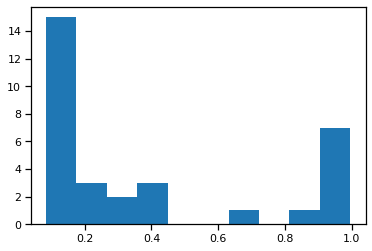

In [15]:
plt.hist(z)

(array([15.,  3.,  2.,  3.,  0.,  0.,  1.,  0.,  1.,  7.]),
 array([0.0210091 , 0.04380209, 0.06659508, 0.08938807, 0.11218105,
        0.13497405, 0.15776703, 0.18056002, 0.20335302, 0.226146  ,
        0.248939  ], dtype=float32),
 <a list of 10 Patch objects>)

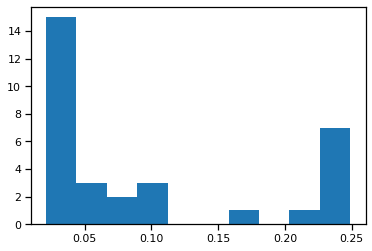

In [16]:
plt.hist(z/4.)

In [17]:
mass = np.array([g['true_params'][0] for g in galaxies])

(array([2., 4., 1., 1., 2., 0., 2., 8., 4., 8.]),
 array([0.31190366, 0.38035032, 0.448797  , 0.5172436 , 0.5856903 ,
        0.65413696, 0.7225836 , 0.7910303 , 0.8594769 , 0.9279236 ,
        0.99637026], dtype=float32),
 <a list of 10 Patch objects>)

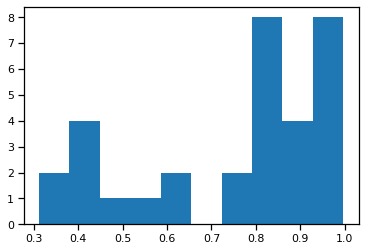

In [18]:
plt.hist(mass)

(array([2., 4., 1., 1., 2., 0., 2., 8., 4., 8.]),
 array([0.31190366, 0.38035032, 0.448797  , 0.5172436 , 0.5856903 ,
        0.65413696, 0.7225836 , 0.7910303 , 0.8594769 , 0.9279236 ,
        0.99637026], dtype=float32),
 <a list of 10 Patch objects>)

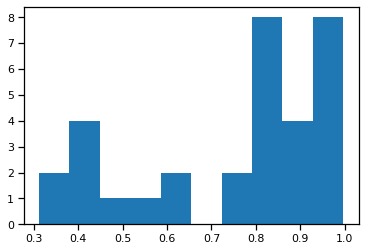

In [19]:
plt.hist(mass)

In [20]:
# galaxy_locs = [x for x in all_galaxy_locs if 'galaxy__' in x]

In [21]:
# galaxy_locs

In [22]:
# n_chains = 256
# # n_chains = 64
# # n_chains = 1
# by_chain = np.reshape(galaxy['samples'], (-1, n_chains, 8))

In [23]:
# by_chain = np.stack([np.squeeze(g['samples']) for g in galaxies], axis=1)
# by_chain.shape

In [24]:
# by_chain.shape
by_chain_raw = galaxy['samples']
param_dim = len(galaxy['true_params'])

In [25]:
# from agnfinder.tf_sampling.hmc import get_covariances

In [26]:
# cov, inv = get_covariances(by_chain)

In [27]:
# cov_np = np.cov(by_chain[:, 0].transpose())
# diag_mask = np.eye(8, 8).astype(bool)
# cov_masked = cov_np.copy()
# cov_masked[diag_mask] = np.nan

In [28]:
# np.matmul(x-x.mean(), (y-y.mean()).transpose())/len(x)

In [29]:
# x = by_chain[:, 0, 0]
# y = by_chain[:, 0, 4]
# plt.scatter(x, y)

In [30]:
# def manual_covariance(x, y):
#     x_mu = x.mean()
#     y_mu = y.mean()
#     return np.mean((x - x_mu)*(y-y_mu))

In [31]:
# manual_covariance(x, y) / (x.std() * y.std())

In [32]:
# d = np.stack([x, y])
# print(d.shape)
# np.cov(d)

In [33]:
# sns.heatmap(cov_np)

In [34]:
# sns.heatmap(cov_masked)

In [35]:
# np.sqrt(cov[0])

In [36]:
# sns.heatmap(cov[0])

In [37]:
by_chain_raw[0:10, 1, :]

array([[8.77024829e-01, 8.48884821e-01, 7.66042113e-01, 2.17721034e-02,
        8.45651329e-01, 9.29751337e-01, 2.45963350e-01, 2.16613352e-01,
        6.15249405e+01],
       [8.70724857e-01, 8.25304866e-01, 7.66362071e-01, 3.03821024e-02,
        8.48951340e-01, 9.23531294e-01, 2.37493351e-01, 1.96663350e-01,
        6.15308990e+01],
       [8.38404834e-01, 8.34314823e-01, 7.81342089e-01, 8.49521011e-02,
        8.53501320e-01, 9.29661334e-01, 3.05173337e-01, 1.41863346e-01,
        6.15208015e+01],
       [8.79684865e-01, 8.22854877e-01, 7.58672059e-01, 6.08921014e-02,
        8.46061349e-01, 9.22781348e-01, 2.74553359e-01, 1.95223346e-01,
        6.15272102e+01],
       [8.27264845e-01, 8.15054834e-01, 7.50452101e-01, 9.83920991e-02,
        8.72621298e-01, 9.22051311e-01, 2.64573365e-01, 1.17363349e-01,
        6.15206490e+01],
       [8.47964823e-01, 8.03864837e-01, 7.18702078e-01, 5.17521016e-02,
        8.73381317e-01, 9.13451314e-01, 2.61383355e-01, 1.20683350e-01,
        6.1

In [38]:
by_chain_raw[4995:5005, 1, :]

array([[ 0.70556486,  0.5454649 ,  0.35695213,  0.86199206,  0.9226113 ,
         0.9704113 ,  0.7472234 ,  0.28668335, 61.53117   ],
       [ 0.72918487,  0.48756483,  0.37239212,  0.8991421 ,  0.9100713 ,
         0.97487134,  0.7507334 ,  0.26353335, 61.53408   ],
       [ 0.68879485,  0.59552485,  0.40817213,  0.9401421 ,  0.8998913 ,
         0.9970513 ,  0.77555335,  0.18886335, 61.53211   ],
       [ 0.71323484,  0.6170148 ,  0.4723221 ,  0.9012521 ,  0.8862413 ,
         0.9988213 ,  0.77866334,  0.23922335, 61.52904   ],
       [ 0.71323484,  0.6170148 ,  0.4723221 ,  0.9012521 ,  0.8862413 ,
         0.9988213 ,  0.77866334,  0.23922335, 61.52904   ],
       [ 0.71645254,  0.60023254,  0.46827596,  0.89949596,  0.8849751 ,
         0.99687505,  0.766852  ,  0.222932  , 61.528515  ],
       [ 0.7076125 ,  0.61055255,  0.425376  ,  0.920096  ,  0.892665  ,
         0.98527503,  0.746922  ,  0.156752  , 61.517715  ],
       [ 0.6791625 ,  0.5540025 ,  0.453426  ,  0.947576  ,  0

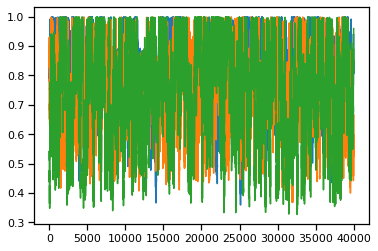

In [39]:
plt.plot(by_chain_raw[:, :3, 0])

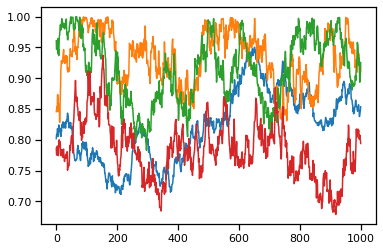

In [40]:
plt.plot(by_chain_raw[:1000, :4, 4])

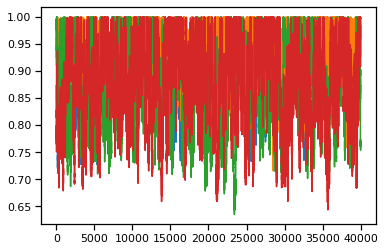

In [41]:
plt.plot(by_chain_raw[:, :4, 4])

In [42]:
by_chain_raw[0, 0]

array([ 0.9260943 ,  0.9437943 ,  0.39330173,  0.31834173,  0.8019896 ,
        0.9438196 ,  0.21525487,  0.5947149 , 61.46227   ], dtype=float32)

In [43]:
by_chain_raw[1, 0]

array([ 0.9071243 ,  0.9109943 ,  0.40856174,  0.28423172,  0.8086596 ,
        0.94828963,  0.16834487,  0.61220485, 61.45811   ], dtype=float32)

In [44]:
def get_kl_vs_other_chains(chains, min_p=1e-5):
    n_chains = chains.shape[1]
    n_params = chains.shape[2]
    kl_divs = np.zeros([n_params, n_chains]) * np.nan
#     for param_n in range(n_params):
    for param_n in [0]:
        for chain_n in range(n_chains):
#             print(param_n, chain_n)
    #     for chain_n in [1]:
            mask = np.ones(n_chains).astype(bool)
            mask[chain_n] = False
            this_chain = chains[:, chain_n]
    #         other_chains = chains[:, mask]
            other_chains = chains
    #         print(this_chain.shape, other_chains.shape)
            bins = np.linspace(0., 1., 10)
            other_probs, _ = np.histogram(other_chains[:, :, param_n], density=True, bins=bins)
            this_probs, _ = np.histogram(this_chain[:, param_n], density=True, bins=bins)
            allowed_probs = (other_probs > min_p) & (this_probs > min_p)
    #         plt.plot(this_probs)~
    #         plt.plot(other_probs)
    #         print(other_probs)
    #         print(this_probs)
            kl_divs[param_n, chain_n] = entropy(other_probs[allowed_probs], this_probs[allowed_probs])  # calculates KL of q (second arg) approximating p (first arg)
    return kl_divs

In [45]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
# print(kl_divs)

In [46]:
# fig, axes = plt.subplots(nrows=by_chain.shape[2], figsize=(8, 12))
# for n, ax in enumerate(axes):
#     ax.hist(kl_divs[n])
# fig.tight_layout()

In [47]:
worst_chain_n = np.argmax(kl_divs)
worst_chain_n

4

In [48]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
kl_divs = kl_divs[0]
print(kl_divs)
kl_is_successful = kl_divs < (np.median(kl_divs) + kl_divs.std() * 2)

typical_std = np.median(by_chain_raw.std(axis=0)[:, 0])
chain_stds = by_chain_raw.std(axis=0)[:, 0]
std_is_successful = chain_stds > typical_std * 0.1

print(std_is_successful)
chain_is_successful = kl_is_successful & std_is_successful
print(chain_is_successful)

[0.11538577 0.07371984 0.00843738 0.06423567]
[ True  True  True  True]
[ True  True  True  True]


(array([1., 0., 0., 0., 0., 1., 1., 0., 0., 1.]),
 array([0.00843738, 0.01913222, 0.02982706, 0.0405219 , 0.05121673,
        0.06191157, 0.07260641, 0.08330125, 0.09399609, 0.10469093,
        0.11538577]),
 <a list of 10 Patch objects>)

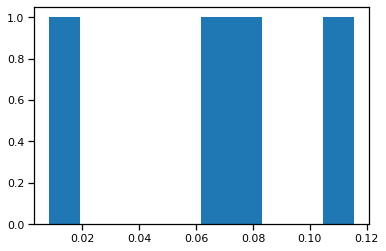

In [49]:
plt.hist(kl_divs, bins=10)

In [50]:
# chain_is_successful = True

In [51]:
by_chain = by_chain_raw

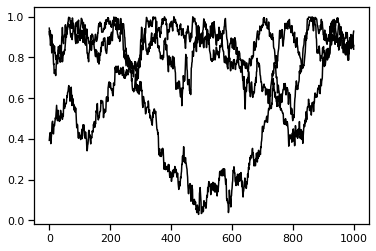

In [53]:
# plt.plot(by_chain_raw[:1000, chain_is_successful, 0].mean(axis=1), 'k--')
plt.plot(by_chain_raw[:1000, chain_is_successful, 0][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 1][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 2][:, 0], color='k')
if np.any(~chain_is_successful):
    plt.plot(by_chain_raw[:1000, ~chain_is_successful, 0][:, 0], color='r')

(array([  143.,  1969.,  7032., 13456., 19336., 23220., 23788., 25159.,
        23549., 22348.]),
 array([0.25706556, 0.3313576 , 0.40564963, 0.47994167, 0.55423373,
        0.62852573, 0.7028178 , 0.7771098 , 0.85140187, 0.92569387,
        0.99998593], dtype=float32),
 <a list of 10 Patch objects>)

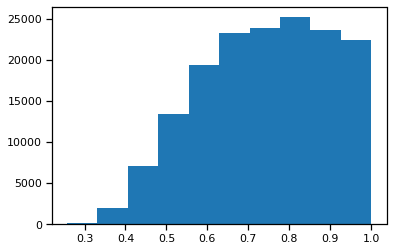

In [54]:
plt.hist(by_chain_raw[:, chain_is_successful, 0].flatten())

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

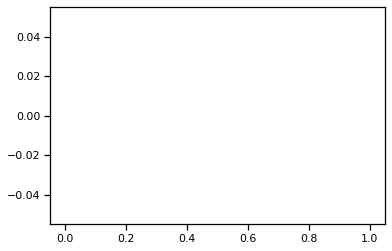

In [55]:
plt.hist(by_chain_raw[:, ~chain_is_successful, 0].flatten())

In [56]:
# from sklearn.metrics import adjusted_mutual_info_score

# adjusted_mutual_info_score(by_chain[:, 0, 0], by_chain[:, 4, 0])

In [57]:
# _ = corner.corner(by_chain[:500].reshape(-1, 8), labels=params)  # early phase only

In [58]:
# _ = corner.corner(by_chain[-5000:].reshape(-1, 8), labels=params)  # late phase only

In [59]:
true_params = galaxy['true_params']

In [60]:
true_params

array([ 0.6087112 ,  0.94446635,  0.8363142 ,  0.80919415,  0.9206015 ,
        0.9684328 ,  0.41467747,  0.9890484 , 61.479355  ], dtype=float32)

In [61]:
def plot_corner(samples, true_params, labels):
    fig = corner.corner(samples, labels=labels)

    # Extract the axes
    axes = np.array(fig.axes).reshape((param_dim, param_dim))

    # Loop over the diagonal
    for i in range(param_dim):
        ax = axes[i, i]
        ax.axvline(true_params[i], color="g")

    true_params = galaxy['true_params']
    # Loop over the histograms
    for yi in range(param_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_params[xi], color="g")
            ax.axhline(true_params[yi], color="g")

    fig

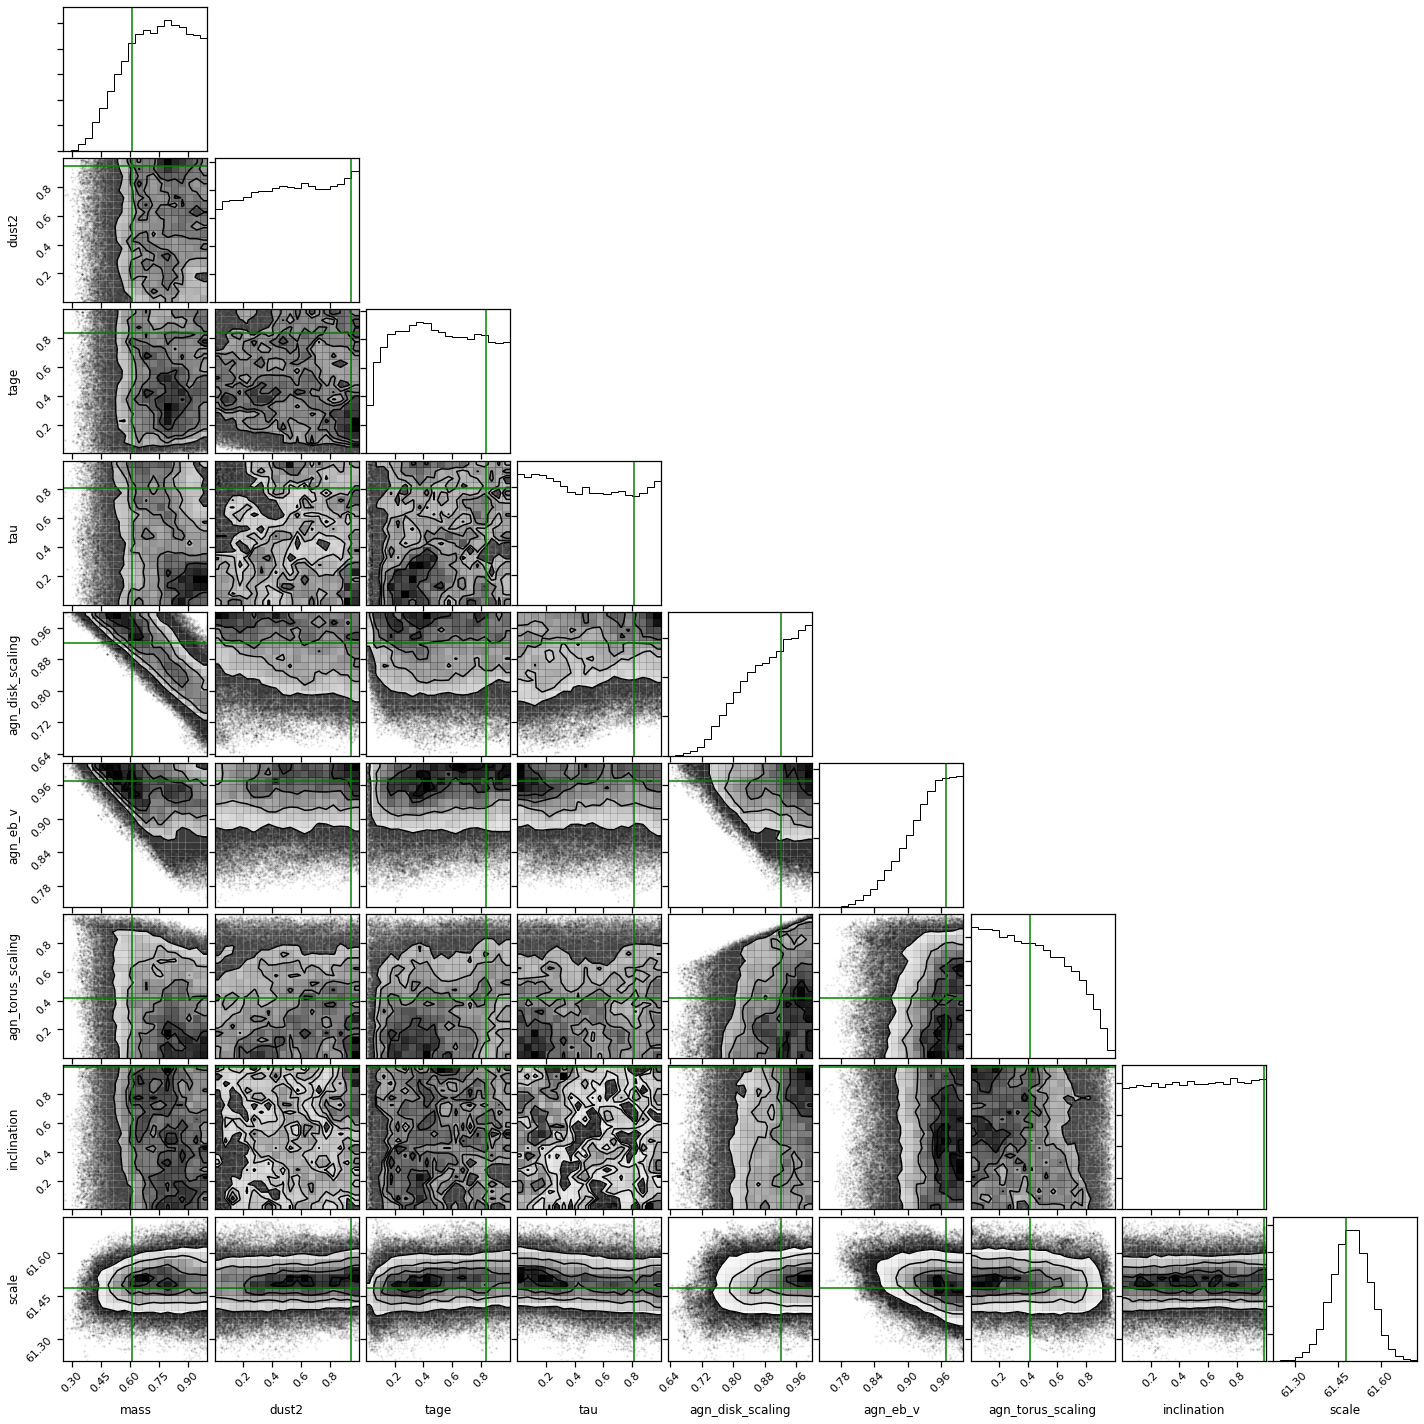

In [62]:
plot_corner(galaxy['samples'].reshape(-1, param_dim), true_params, params)

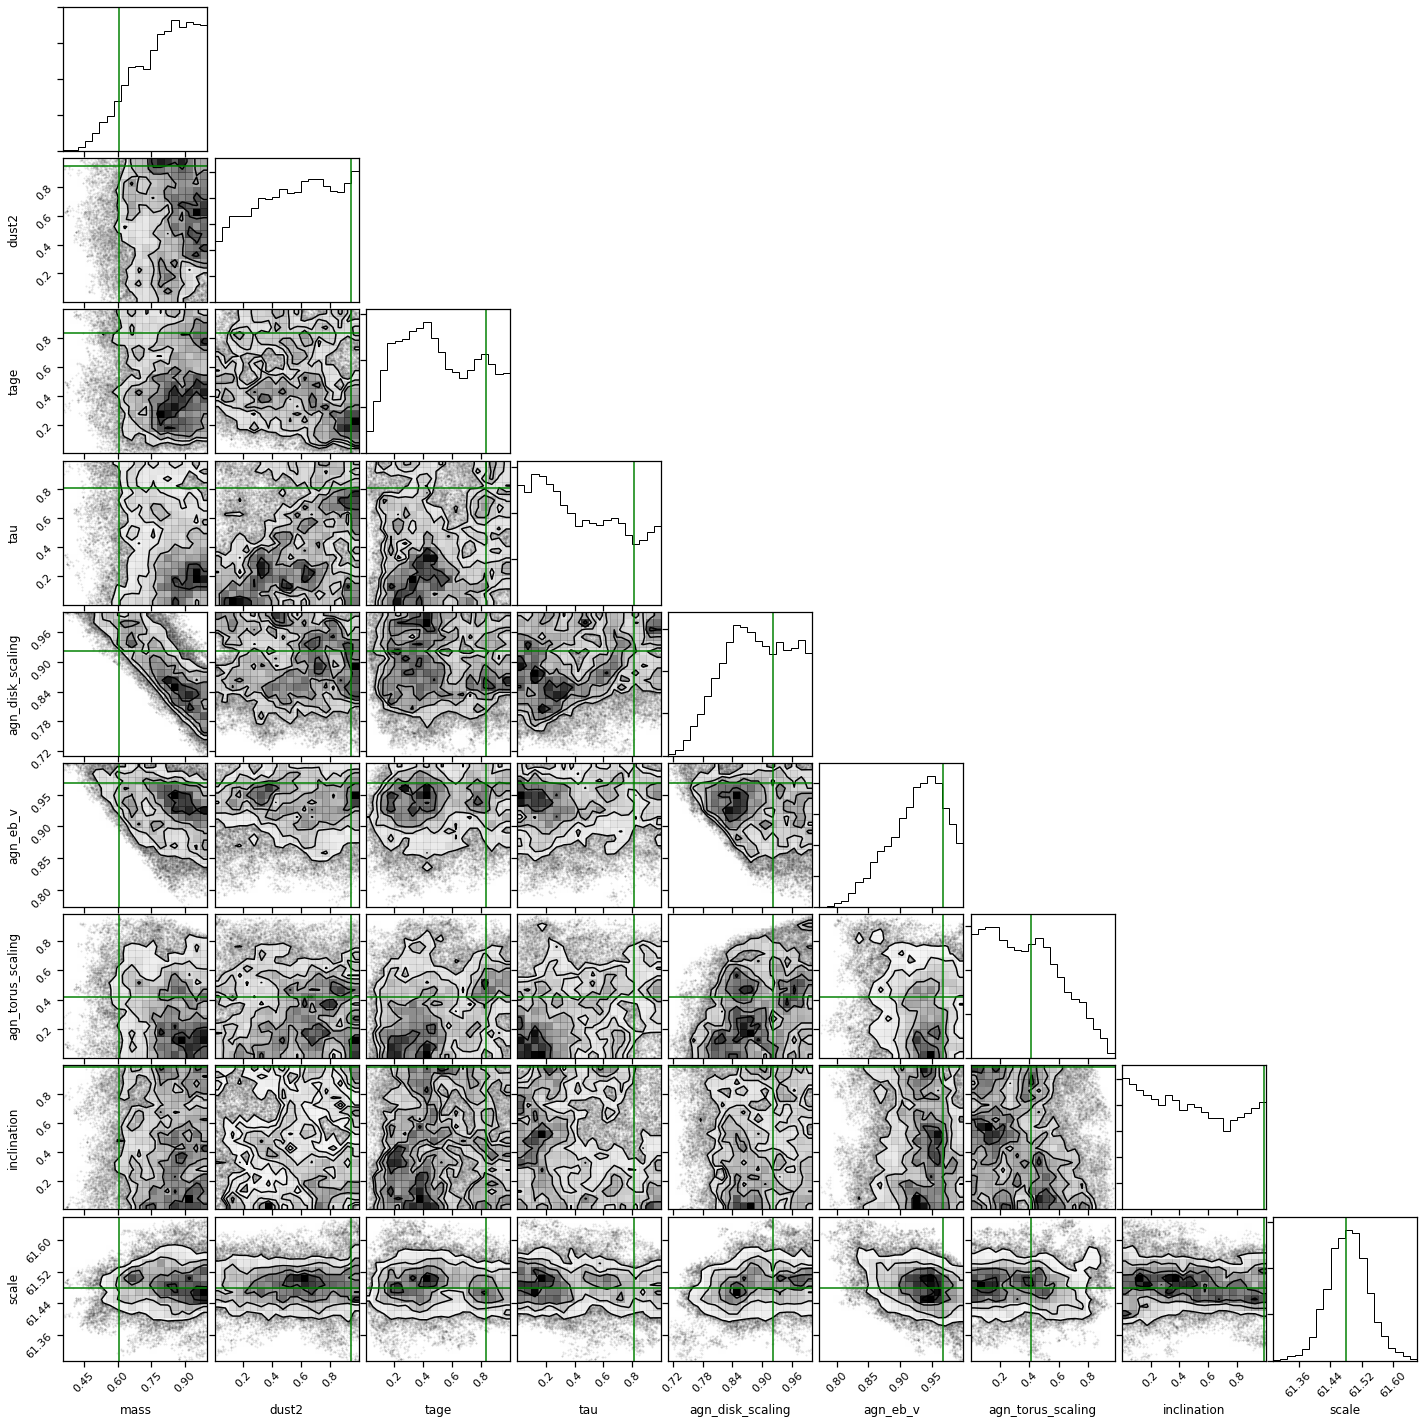

In [63]:
plot_corner(galaxy['samples'][:, 0], true_params, params)

In [64]:
# plot_corner(by_chain_raw.reshape(-1, param_dim), true_params, params)

In [65]:
# _ = corner.corner(by_chain.reshape(-1, param_dim), labels=params)

In [66]:
# import tensorflow_probability as tfp
# import tensorflow as tf

In [67]:
# samples = by_chain.reshape(-1, param_dim)
# mu = np.mean(samples, axis=0)

# cov = np.loadtxt('latest_cov.npy').astype(np.float32)
# # cov = tfp.stats.covariance(samples)  # or just np cov?
# chol = tf.linalg.cholesky(cov)
# approx_dist = tfp.distributions.MultivariateNormalTriL(
#     loc=mu, scale_tril=chol, validate_args=True, allow_nan_stats=False
# )


# bijector = tfp.bijectors.ScaleMatvecTriL(scale_tril=chol)

In [68]:
# bijector

In [69]:
# b = tfp.bijectors.ScaleMatvecTriL(scale_tril=[chol for _ in range(by_chain.shape[1])])


In [70]:
# b.inverse(by_chain).shape

TensorShape([40000, 4, 9])

In [72]:
# approximated_samples = approx_dist.sample(10000)
# _ = corner.corner(approximated_samples, range=[[0, 1] for _ in range(8)])
# # only mass/agn mass are strongly covariant, but the std of many params is very different (as expected, and already dealt with)

In [ ]:
# uniform = tf.random.uniform([10000, 8])
# _ = corner.corner(bijector.forward(uniform))

In [ ]:
# sns.heatmap(cov)

In [ ]:
# from agnfinder.tf_sampling.hmc import get_decorrelation_bijector

In [ ]:
# observation_ids = [np.random.choice(['a', 'b']) for _ in range(by_chain.shape[1])]

In [ ]:
# batch_bijector = get_decorrelation_bijector(by_chain, observation_ids)

In [ ]:
# batch_bijector.forward_event_shape(tf.shape(uniform))

In [ ]:
# batch_bijector.inverse(np.array([uniform for _ in range(29)]))

In [ ]:
# for n in [100, 500, 5000]:
#     b = get_decorrelation_bijector(by_chain[:n, 0])  # even w/ 1 chain, 1000 is about enough
#     _ = corner.corner(b.inverse(samples))


In [ ]:
# for n in [100, 1000, 5000]:
#     b = get_decorrelation_bijector(samples[:n])  # merging across chains,  
#     _ = corner.corner(b.inverse(samples))


In [ ]:
# assert False

In [ ]:
# _ = corner.corner(bijector.inverse(approximated_samples))

These have weird ranges, but are actually same scale - about 6

In [73]:
# _ = corner.corner(bijector.inverse(samples))

In [74]:
# _ = corner.corner(by_chain_not_bad[::10].reshape(-1, 8), labels=params)

## Marginals

### Marginals, cut by n-samples

In [75]:
def get_marginals(samples, marginal_bins=100, param_dim=9):
    dummy_array = np.zeros(42)  # anything
    _, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)

    marginals = np.zeros((param_dim, marginal_bins))
    for param_n in range(param_dim):
        marginals[param_n], _ = np.histogram(samples[:, :, param_n].flatten(), density=True, bins=param_bins)  # galaxy samples is still dim3, confusingly

    return marginals, param_bins

In [76]:
params

array(['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v',
       'agn_torus_scaling', 'inclination', 'scale'], dtype=object)

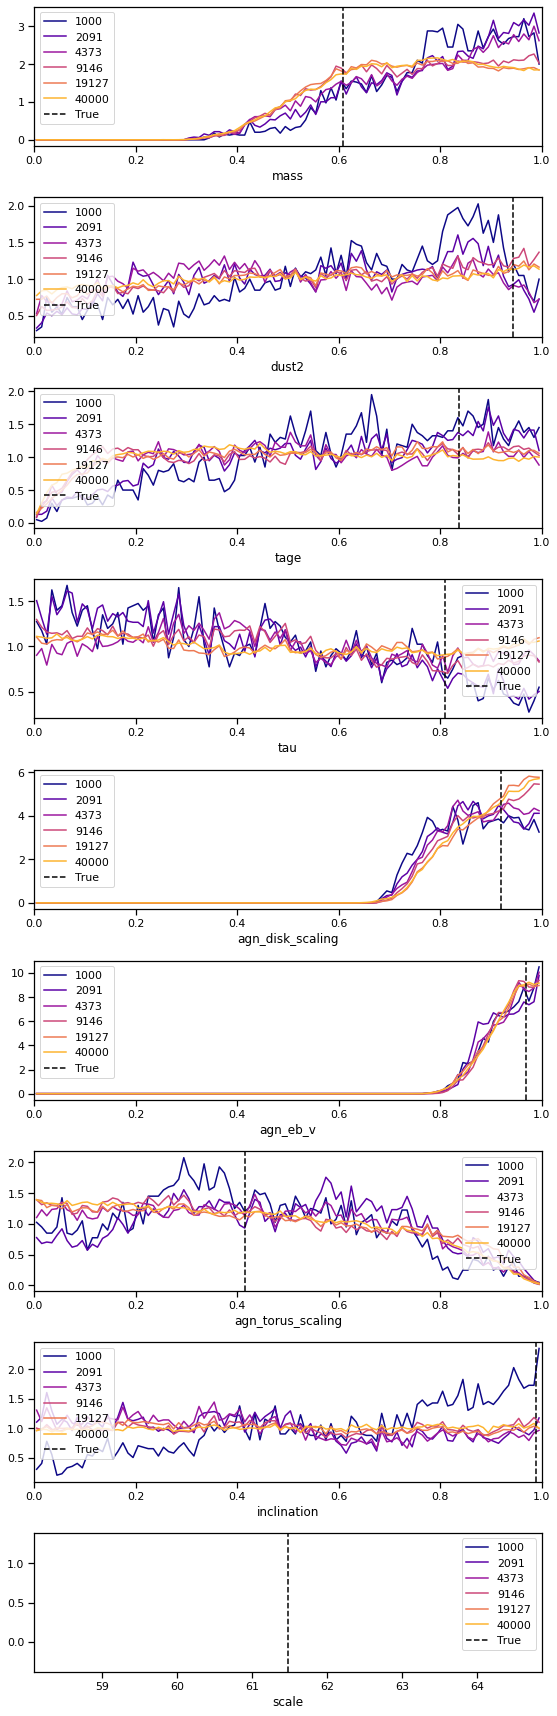

In [83]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

# limits = [
#     [0., 1.],
# #     [.5, .6],
#     [.1, .5],
#     [0., .2],
#     [0., 0.2],
#     [0., 0.7],
#     [0., 1.],
#     [0., 0.6],
#     [0., 1.]
# ]
limits = [[0., 1.] for _ in range(len(params))]
limits[-1] = [None, None]  # scale parameter don't mess with

cuts = np.logspace(3, np.log10(len(by_chain)), num=6).astype(int)
# tau_est = np.array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453]) / 10.

max_chains = 32

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(cuts):
        marginals, bins = get_marginals(galaxy['samples'][:cut, :max_chains, :], marginal_bins=100, param_dim=len(params))
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=cut)
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()
    

### Marginals, cut by n-chains

Note that this is only relevant for HMC, as the performance by-chain for emcee is not defined - chains are dependent!

In [78]:
true_params = galaxy['true_params']
true_params

array([ 0.6087112 ,  0.94446635,  0.8363142 ,  0.80919415,  0.9206015 ,
        0.9684328 ,  0.41467747,  0.9890484 , 61.479355  ], dtype=float32)

In [84]:
galaxy['samples'].shape[1]

4

In [85]:
galaxy['samples'].shape

(40000, 4, 9)

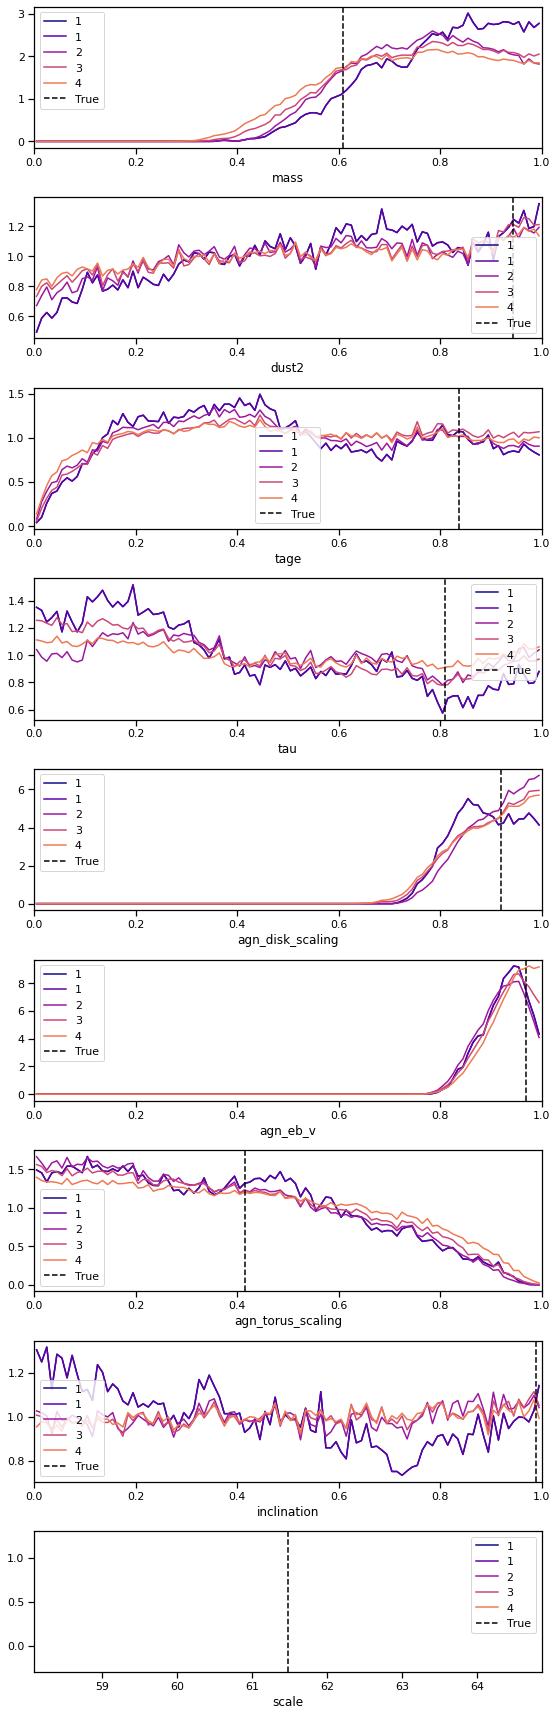

In [82]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, galaxy['samples'].shape[1], num=5).astype(int)
max_samples = 40000

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain[:max_samples, :cut, :], param_dim=len(params))
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

## Identify bad chains, and remove them.

HMC only, as emcee chains are dependent.
For emcee, starting in a ball should prevent this anyway?

In [ ]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [ ]:
ds = az.convert_to_dataset(np.swapaxes(by_chain, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity
# ds_hmc = az.convert_to_dataset(np.swapaxes(by_chain_not_bad, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [ ]:
ds

In [ ]:
# Trim the most extreme 5% percentiles?
mass_samples = by_chain[:, :, 0].flatten()
low, high = np.percentile(mass_samples, [2, 98])
print(low, high)
mass_samples_trimmed = mass_samples[(mass_samples > low) & (mass_samples < high)]

In [ ]:
_ = plt.hist(mass_samples, bins=50, alpha=0.5, density=True)
_ = plt.hist(mass_samples_trimmed, bins=50, alpha=0.5, density=True)

In [ ]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

In [ ]:
std_devs = np.random.rand(*by_chain.shape[1:])
observation_ids = [np.random.choice(['a', 'b', 'c']) for _ in range(by_chain.shape[1])]
std_devs_df = pd.DataFrame(data=std_devs, index=observation_ids).reset_index()  # columns are params (int range)
std_devs_by_galaxy = std_devs_df.groupby('index').agg('mean')
# for obs_id in self.observation_ids:

In [ ]:
std_devs_by_galaxy

In [ ]:
dict(zip(std_devs_by_galaxy.index, std_devs_by_galaxy.values))

In [ ]:
std_devs_df.head()

In [ ]:
np.argmax(np.median(by_chain[:, :, 0], axis=0))

In [87]:
forward_model = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), 'results/checkpoints/latest', new=False, cube_dir='data/cubes/latest')

In [88]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])

In [89]:
def get_expected_photometry(x):
    scale = x[:, -1]
#     print(scale)
    p = x[:, :-1]
    x_with_fixed_params = tf.concat([fixed_params, p], axis=1)
    norm_photometry = forward_model(x_with_fixed_params)
#     print(norm_photometry)
    return deep_emulator.denormalise_photometry(norm_photometry, scale=scale).numpy()

In [90]:
fixed_params = galaxy['fixed_params'].reshape(1, -1)
fixed_params

array([[0.4059862]], dtype=float32)

In [91]:
free_params = np.random.rand(param_dim).reshape(1, -1)

In [92]:
fixed_params.shape, free_params.shape

((1, 1), (1, 9))

In [93]:
x = np.concatenate([fixed_params, free_params], axis=1)

In [94]:
get_expected_photometry(free_params)

array([[0.8889207 , 0.8975541 , 0.90225226, 0.9056348 , 0.9068512 ,
        0.90998274, 0.90854067, 0.9068094 ]], dtype=float32)

In [95]:
by_chain[0, 0, :]

array([ 0.9260943 ,  0.9437943 ,  0.39330173,  0.31834173,  0.8019896 ,
        0.9438196 ,  0.21525487,  0.5947149 , 61.46227   ], dtype=float32)

In [96]:
by_chain.shape

(40000, 4, 9)

In [97]:
by_chain = by_chain.squeeze()

In [98]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))

array([[8.0114537e-10, 5.5350808e-09, 1.6632196e-08, 3.5384133e-08,
        4.5590966e-08, 9.4995620e-08, 6.8592179e-08, 4.5960878e-08]],
      dtype=float32)

In [99]:
galaxy['uncertainty']

array([1.2379360e-10, 2.5239083e-10, 3.8105710e-10, 6.0947547e-10,
       2.1745550e-09, 3.4942444e-09, 2.9493408e-09, 1.7535396e-09],
      dtype=float32)

In [101]:
# checkpoint_dir = 'results/checkpoints/latest'
# emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=False)

# from agnfinder.tf_sampling import run_sampler_singlethreaded
# plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='emulator(true params)')



# plt.loglog(wavelengths, fsps(median_params.squeeze()), linestyle='', marker='+', label='FSPS(median params)=observed')
# # get_expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
# fsps_p = fsps(median_params.squeeze())
# plt.loglog(wavelengths, expected_p/expected_p.sum(), linestyle='', marker='+', label='emulator(true params)')
# plt.loglog(wavelengths, fsps_p/fsps_p.sum(), linestyle='', marker='+', label='FSPS(median params)=observed')(emulator)

In [102]:
from agnfinder import simulation_samples
from agnfinder.tf_sampling import deep_emulator
from collections import OrderedDict

In [103]:
fsps, wavelengths, output_dim = simulation_samples.get_forward_model(emulate_ssp=False, noise=False, filter_selection='euclid')

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  agn_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  agn_eb_v: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)
  agn_torus_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  inclination: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=90.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  logzsol: 0.0 
  sfh: 4 
  imf_type: 2 
  dust_type: 2 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 
  add_igm_absorption: True 
 

In [ ]:
true_params

In [ ]:
param_dim

In [ ]:
fixed_params

In [ ]:
by_chain[0, 0, -1]

In [124]:
fsps_free_params = np.median(by_chain, axis=[0, 1])[:-1]  # excluding scale
fsps_scale = np.median(by_chain, axis=[0, 1])[-1]

print(fsps_free_params)
fsps_params = np.concatenate([fixed_params, np.expand_dims(fsps_free_params, axis=0)], axis=1)

print(fsps_params)

# norm_median_params = np.median(by_chain, axis=[0, 1])
# fsps_params = 

# norm_median_params = norm_median_params.reshape(1, -1)
median_params = simulation_utils.denormalise_theta(fsps_params, simulation_samples.FREE_PARAMS)
print(median_params)


[0.750458   0.52454543 0.5068033  0.48001742 0.9028151  0.9446492
 0.39006954 0.5062038 ]
[[0.4059862  0.750458   0.52454543 0.5068033  0.48001742 0.9028151
  0.9446492  0.39006954 0.5062038 ]]
[[1.6239448e+00 1.0042273e+11 1.0490909e+00 6.9943781e+00 1.5454730e+00
  2.4071259e+00 4.7232461e-01 1.5461238e-04 4.5558338e+01]]


Text(0, 0.5, 'Flux (Maggies)')

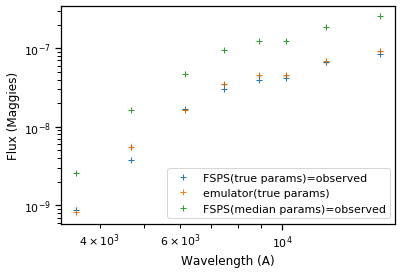

In [126]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='emulator(true params)')



plt.loglog(wavelengths, fsps(median_params.squeeze()), linestyle='', marker='+', label='FSPS(median params)=observed')

for n in range(4):
    plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./16.)
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (Maggies)')

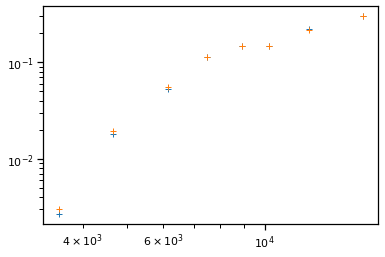

In [127]:
expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
plt.loglog(wavelengths, expected_p/expected_p.sum(), linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_p/fsps_p.sum(), linestyle='', marker='+', label='FSPS(median params)=observed')

Text(0, 0.5, 'Flux (Maggies)')

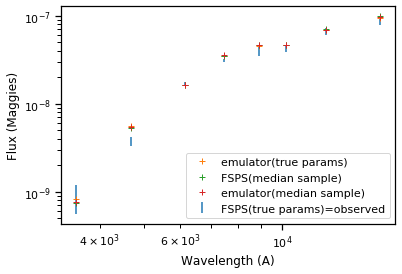

In [131]:
# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
plt.errorbar(x=wavelengths, y=galaxy['true_observations'], yerr=2*galaxy['uncertainty'], linestyle='', label='FSPS(true params)=observed')

expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
# plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
fsps_norm = deep_emulator.normalise_photometry(np.expand_dims(fsps_p, axis=0), rescale=1.)
fsps_flux = np.squeeze(deep_emulator.denormalise_photometry(fsps_norm, scale=fsps_scale))
plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_flux, linestyle='', marker='+', label='FSPS(median sample)')

plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=('emulator(median sample)'))
plt.legend()

# for n in range(15):
#     plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./16.)


plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (Maggies)')



Text(0, 0.5, 'Flux (Maggies)')

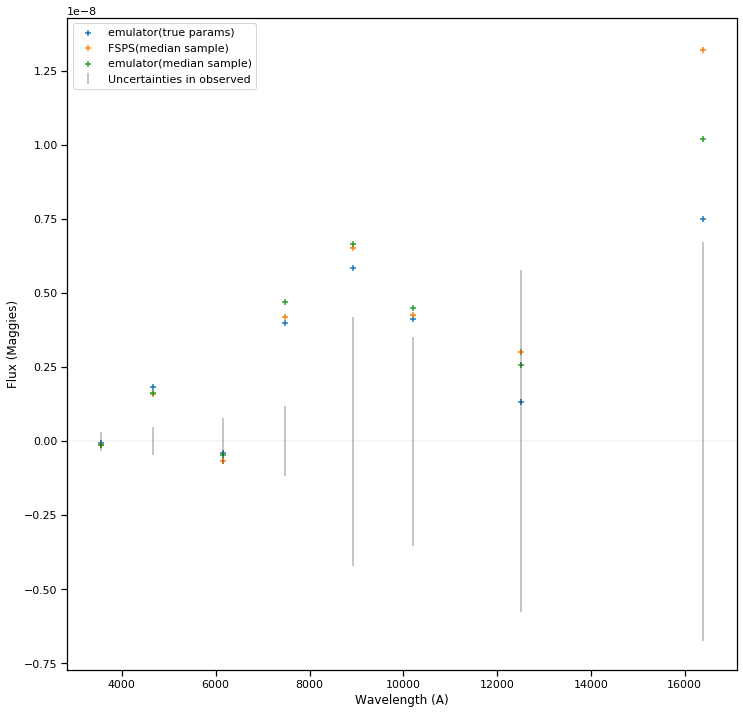

In [130]:
fig, ax = plt.subplots(figsize=(12, 12))

# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
ax.errorbar(x=wavelengths, y=[0 for _ in range(len(fsps_p))], yerr=2*galaxy['uncertainty'], linestyle='', label='Uncertainties in observed', color='k', alpha=0.3)
ax.axhline(0., color='k', alpha=0.05)

expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
# plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
fsps_norm = deep_emulator.normalise_photometry(np.expand_dims(fsps_p, axis=0), rescale=1.)
fsps_flux = np.squeeze(deep_emulator.denormalise_photometry(fsps_norm, scale=fsps_scale))

ax.scatter(wavelengths, expected_p - galaxy['true_observations'], marker='+', label='emulator(true params)')
ax.scatter(wavelengths, fsps_flux - galaxy['true_observations'], marker='+', label='FSPS(median sample)')

ax.scatter(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0] - galaxy['true_observations'], marker='+', label=('emulator(median sample)'))
ax.legend()

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux (Maggies)')



In [169]:
from matplotlib import cm

In [196]:
param_names = ['Redshift', 'Mass', 'Dust', 'Tau', 'Tage', 'Disk Mass', 'Torus Mass', 'Inclination', 'Normalisation']

In [206]:
def show_sed_by_param(params, param_n, ax, title):
    for param_value in np.linspace(0., 1.):
        params[0, param_n] = param_value
        photometry = get_expected_photometry(params)[0]
        ax.loglog(wavelengths, photometry, marker='.', linestyle='', color=cm.magma(params[0, param_n]))
        ax.set_title(title)

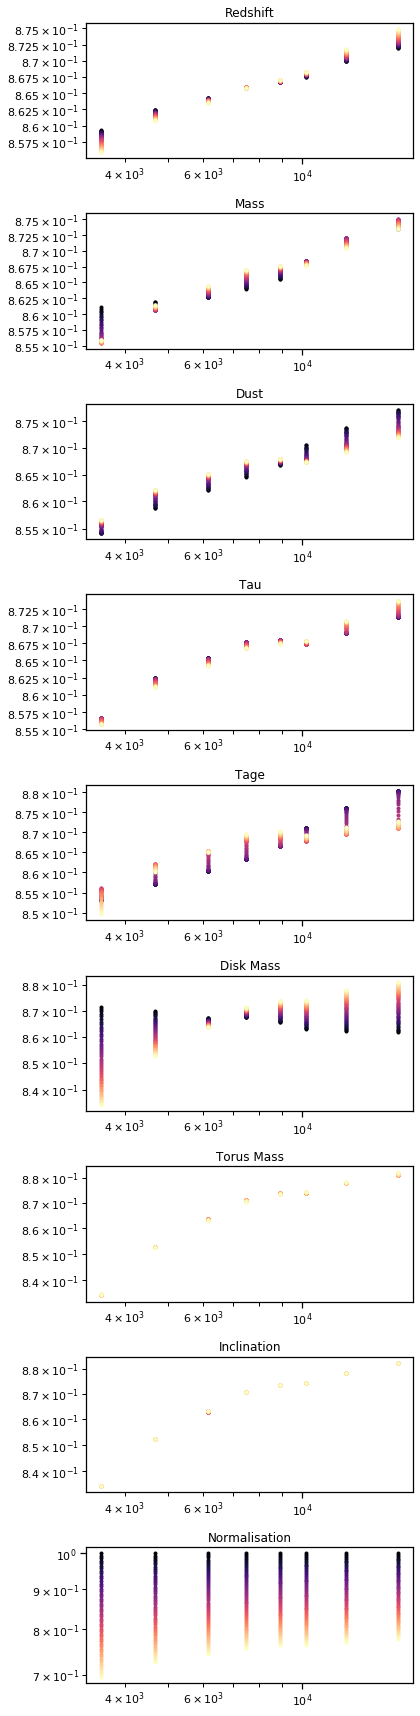

In [207]:
fig, axes = plt.subplots(nrows=9, figsize=(6, 24))
init = 0.5 * np.ones(9).reshape(1, -1)
for param_n in range(9):
    show_sed_by_param(init, param_n, axes[param_n], param_names[param_n])
plt.tight_layout()

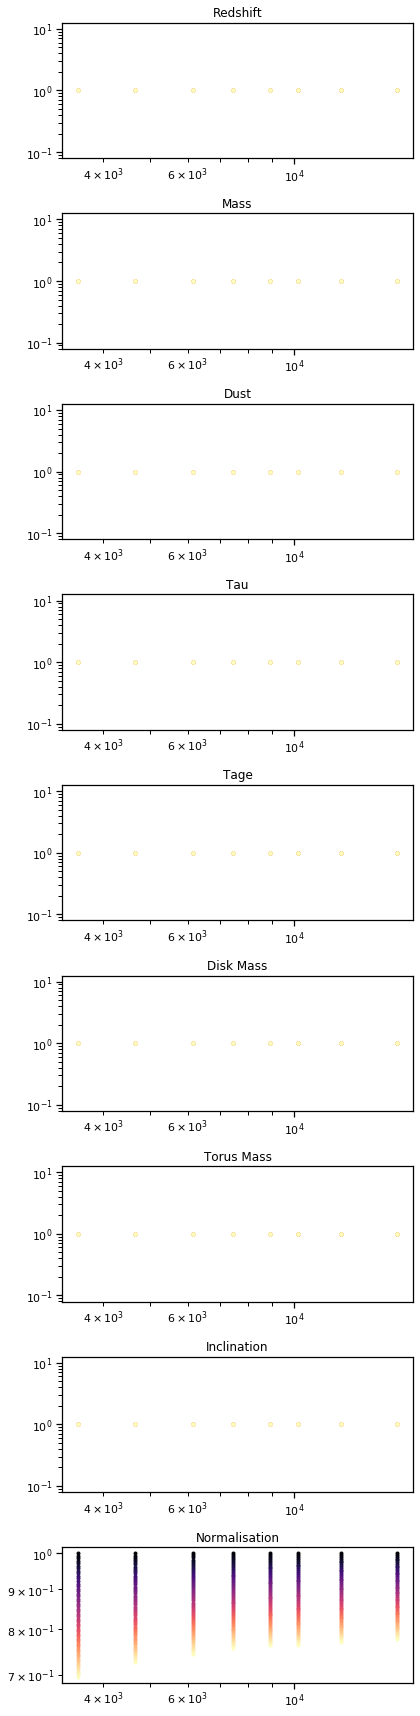

In [208]:
fig, axes = plt.subplots(nrows=9, figsize=(6, 24))
init = 0. * np.ones(9).reshape(1, -1)
for param_n in range(9):
    show_sed_by_param(init, param_n, axes[param_n], param_names[param_n])
plt.tight_layout()

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [1,1] vs. shape[1] = [9,0] [Op:ConcatV2] name: concat

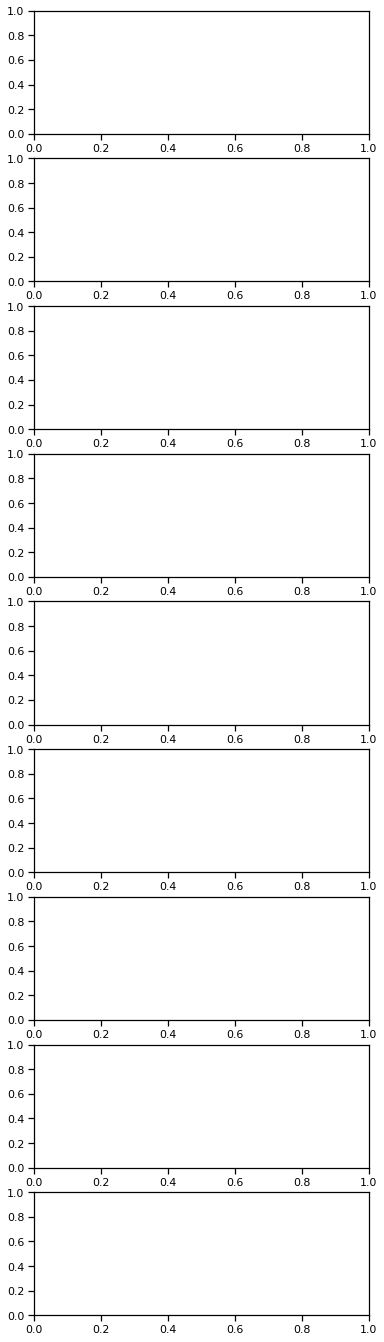

In [213]:
fig, axes = plt.subplots(nrows=9, figsize=(6, 24))
init = np.array([0., 0., 0.5, 0.5, 1., 0., 0., 0., 1.]).reshape(-1, 1)
for param_n in range(9):
    show_sed_by_param(init, param_n, axes[param_n], param_names[param_n])
plt.tight_layout()

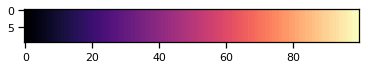

In [209]:
plt.imshow([np.linspace(0, 1, 100) for n in range(10)], cmap=cm.magma)

In [132]:
fsps_scale

61.497284

In [133]:
deep_emulator.denormalise_photometry(-np.log10(fsps_p), scale=fsps_scale)

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [134]:
-np.log10(fsps_p)

array([8.59246506, 7.78381728, 7.33020388, 7.01686841, 6.9048022 ,
       6.59185181, 6.73384087, 6.90359928])

IndexError: index 4 is out of bounds for axis 1 with size 4

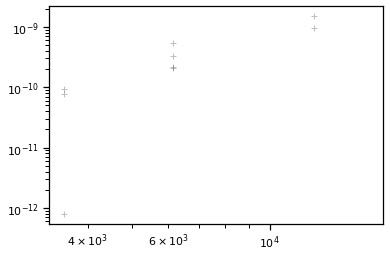

In [135]:
# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='observed')
# plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='true params')
# plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=)
for n in range(15):
    plt.loglog(wavelengths, galaxy['true_observations'] - get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./4.)
# plt.legend()

In [ ]:
plt.axhline(0., linestyle='--')
for n in range(15):
    plt.scatter(wavelengths, galaxy['true_observations'] - get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], marker='+', color='k', alpha=1./4.)
    plt.ylim([-1e-8, 1e-8])
    plt.xscale('log')
# plt.legend()

In [ ]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0]

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true', color='k')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 34, :].reshape(1, -1))[0], linestyle='', marker='+', color='r')

In [ ]:
by_chain_not_bad = np.concatenate([by_chain[:, :34], by_chain[:, 35:]], axis=1)
by_chain_not_bad.shape

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, 51, num=5).astype(int)

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain_not_bad[:, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

In [ ]:
from emcee.autocorr import integrated_time

In [ ]:
# emcee is happy with time, walkers, dimensions
tau_est = integrated_time(by_chain, quiet=True)
tau_est

In [ ]:
# array([ 628.51810087,  656.14108053,  858.91637139,  925.08219734,
#        1049.84372125, 3584.59257398, 1421.13224327, 3356.72261827])

# hmc

In [ ]:
# # emcee is happy with time, walkers, dimensions
# tau_est_not_bad = integrated_time(by_chain_not_bad, quiet=True)
# tau_est_not_bad

In [ ]:
sns.barplot(y=params, x=tau_est)  # estimate tau using all chains

In [ ]:
# extinction and inclination are the most uncertain, both almost totally unknown

In [ ]:
sns.barplot(y=params, x=len(by_chain)/tau_est)  # effective samples per chain

In [ ]:
# hmc, no thinning, 1 chain (probably not a good estimate?):

# array([4594.71930395, 4106.71578812, 3291.08818621, 4068.70526458,
#        2642.20579738, 6012.44976159, 5008.85703236, 5370.88693979])

In [ ]:
# 100k samples, 30k burnin, no thinning, 256 walkers, emcee:
    
# array([4747.67220695, 4897.18058522, 5929.65856414, 5970.30192595,
#        4055.12796419, 2566.78810495, 3377.97829428, 2423.96171419])

# (too short for reliable estimate)

In [ ]:
tau_est * 10  # in real samples, prop.compute time

In [ ]:
# 100k samples, 30k burnin, 10x thinning, 256 walkers, emcee:
    
# array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453])



In [ ]:
# 100k samples HMC, 10k burnin, 10x thinning, 64 walkers, hmc:
    
# array([ 6285.1810087 ,  6561.41080526,  8589.1637139 ,  9250.82197341,
#        10498.43721253, 35845.92573981, 14211.32243268, 33567.22618269])

In [ ]:
geweke = az.geweke(np.swapaxes(galaxy['samples'], 0, 1))
geweke.shape
# plt.plot(geweke[:, 1])

In [ ]:
geweke

In [ ]:
plt.plot(geweke[:, 0])

In [ ]:
rhat = az.rhat(ds)
rhat_values = rhat.x.values
print('Not valid for emcee! walkers are correlated')
print('Values greater than one indicate that one or more chains have not yet converged.')
for n, p in enumerate(params):
    print(p, '{:.2f}'.format(rhat_values[n]))

In [ ]:
# may not be valid for walkers?

In [ ]:
_ = az.plot_autocorr(ds, max_lag=4000, combined=True)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds.x[0:1].values, max_lag=5000)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds.x[2:3].values, max_lag=5000)  # in thinned units

In [ ]:
# ds.x[30, 100, 7]  # ds.x format is (chain, sample, param)

In [ ]:
_ = az.plot_mcse(ds)

In [ ]:
ds_hmc

In [ ]:
ess = az.ess(ds_hmc)

In [ ]:
ess.x.values

In [ ]:
sns.barplot(y=params, x=ess.x.values)

In [ ]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

In [ ]:
_ = az.plot_ess(ds, kind="quantile")

In [ ]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")

In [ ]:
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/backends/backend.py#L130
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/autocorr.py#L47